### Import relevant library

In [14]:
import os
import importlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import clustering_slidwin as clustering
from nilearn.plotting import plot_roi
from nilearn.image import load_img
from scipy.stats import chi2_contingency, f_oneway

importlib.reload(clustering)

from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

<module 'clustering_slidwin' from 'C:\\Users\\smine\\OneDrive\\Documents\\GitHub\\biotypes\\reproducibility_analysis\\slidwin_repro_analysis\\clustering_slidwin.py'>

### Load input data

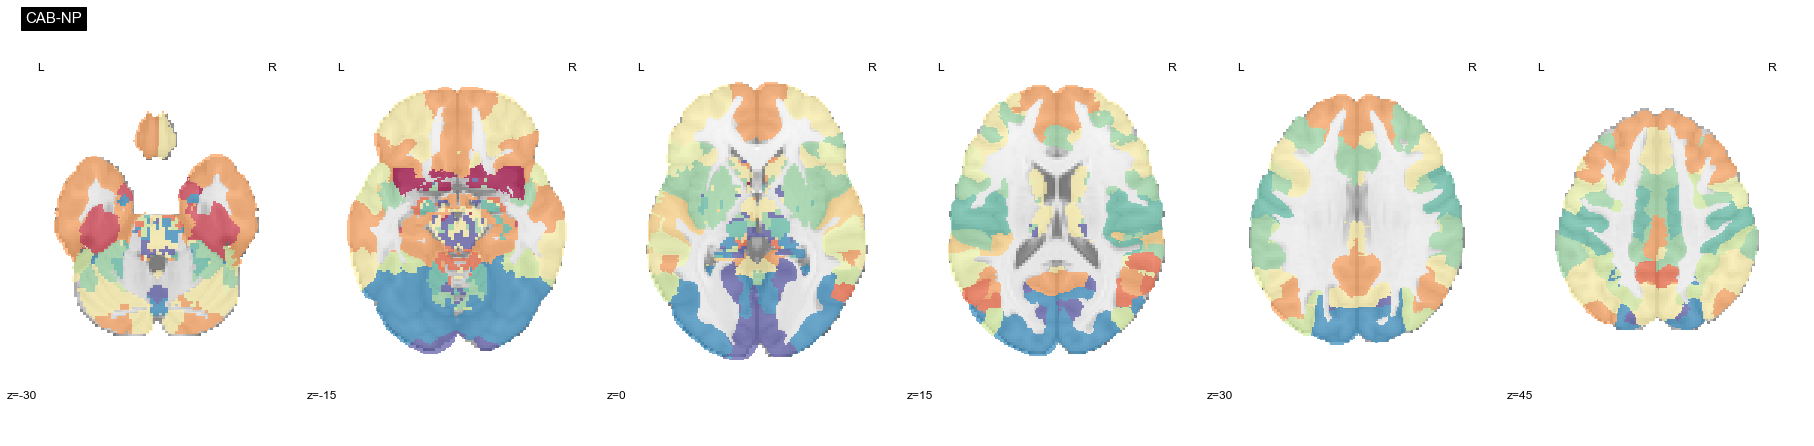

In [2]:
connectomes_matrices_extracted_dirpath = '../../connectomes_extraction_multi_TR/connectomes_matrix/updated_matrices/'
datasets_names_list = os.listdir(connectomes_matrices_extracted_dirpath)
atlas_name = 'CAB-NP'
sliding_windows_number = 5

atlas_path = os.path.abspath('../atlas')
atlas = load_img('../../../atlas/CAB-NP_volumetric/CAB-NP_volumetric_liberal.nii.gz')

fig = plt.figure(figsize=(25,6))
plot_roi(atlas,
        display_mode='z',
        cut_coords=[-30,-15,0,15,30,45],
        title = atlas_name,
        figure=fig,
        annotate=True,
        draw_cross=False,
        black_bg=False,
        colorbar=False,
        vmin=0.8,
        vmax=12+0.2,
        cmap='Spectral_r'
                    )

### Participants information

In [3]:
datasets_participants_info_list = []
for dataset_name in datasets_names_list:
    participants_info_per_dataset = clustering.get_dataset_participants_info_tsv(connectomes_matrices_extracted_dirpath,
                                                                                dataset_name)
    datasets_participants_info_list.append(participants_info_per_dataset)

participants_info_concat = pd.concat(datasets_participants_info_list, axis=0, join='inner')
participants_info_merged = clustering.merge_datasets_participants_info(datasets_participants_info_list)
participants_info_merged.describe(include='all')

,sex,age,dataset
count,66,66.000000,66
unique,2,NaN,5
top,M,NaN,mdtb
freq,33,NaN,24
mean,NaN,29.045455,NaN
std,NaN,6.828519,NaN
min,NaN,19.000000,NaN
25%,NaN,24.000000,NaN
50%,NaN,27.000000,NaN
75%,NaN,33.750000,NaN


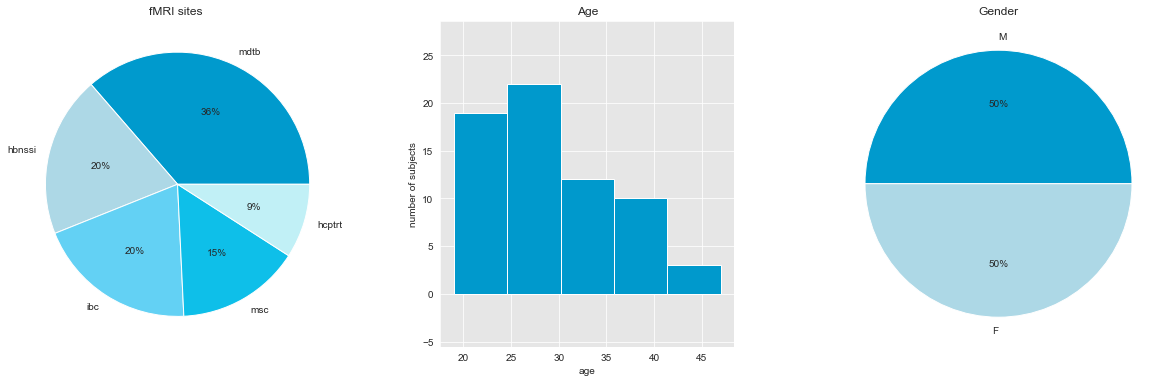

In [4]:
age = participants_info_merged['age']
gender_counts =  participants_info_merged['sex'].value_counts()
datasets_counts = participants_info_merged['dataset'].value_counts()

fig, axs= plt.subplots(1,3, figsize=(20,6))
fig.subplots_adjust(wspace=0.4);

color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9', '#C1F0F6', '#0099CC']

axs[0].pie(datasets_counts, labels=datasets_counts.index, colors = color_palette_list[:len(datasets_counts)],
           autopct='%1.0f%%', shadow=False, startangle=0);
axs[0].axis('equal');
axs[0].set_title('fMRI sites');

axs[1].hist(age, bins=5, color = color_palette_list[-1], label= age.index);
axs[1].set_title('Age');
axs[1].set_xlabel('age')
axs[1].set_ylabel('number of subjects')
axs[1].axis('equal');

axs[2].pie(gender_counts, labels=gender_counts.index, colors = color_palette_list[:len(gender_counts)], autopct='%1.0f%%',
       shadow=False, startangle=0);
axs[2].axis('equal');
axs[2].set_title('Gender');

### Datasets statistical results

In [5]:
dataset_name = datasets_names_list[0]
time_chunks_dirpath = os.path.join(connectomes_matrices_extracted_dirpath, dataset_name, atlas_name,'0')
time_chunks = os.listdir(time_chunks_dirpath)
time_chunks_filtered = list(filter(lambda num: int(num) <= 60, time_chunks))
time_chunks_filtered.sort(key=float)
time_chunks_filtered= list(map(int, time_chunks_filtered))

In [8]:
connectome_matrice_mean_intersubjects_matlist = []
connectome_matrice_stdmean_intersubjects_matlist = []
pairwise_spearmanr_list = []
slidwin_initial = 0

Text(0.5, 1.0, 'Intersubject connectomes mean vs time chunks')

Text(0.5, 1.0, 'Intersubject connectomes std mean vs time chunks')

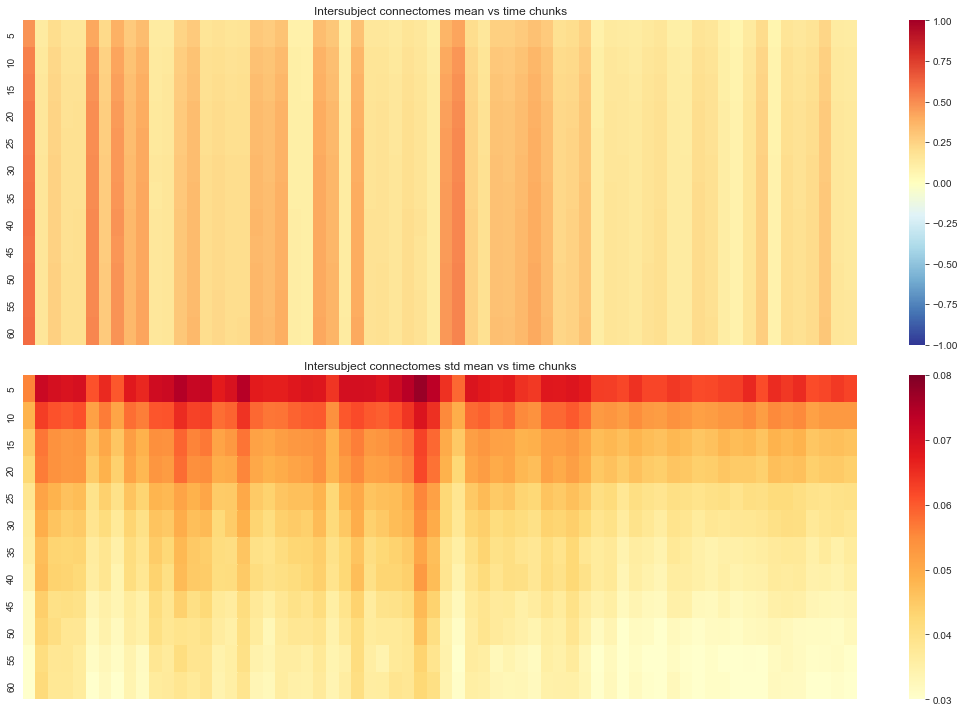

In [13]:
for time in time_chunks_filtered:
    connectomes_matrices_per_chunks_list = []
    connectomes_matrices_keys_multiindex = []
    matricesFiles_path = clustering.get_minMatrix(connectomes_matrices_extracted_dirpath, datasets_names_list,
                                                  atlas_name, str(slidwin_initial), str(time))
    for dataset_name in datasets_names_list:
        connectomes_matrices_per_time_chunks_dirpath = os.path.join(connectomes_matrices_extracted_dirpath, dataset_name,
                                                                    atlas_name, str(slidwin_initial), str(time))

        for connectomes_matrices_path in matricesFiles_path:
            connectome_matrix = pd.read_csv(os.path.join(connectomes_matrices_per_time_chunks_dirpath,
                                                     connectomes_matrices_path), header=None, index_col=0)
            connectomes_matrices_per_chunks_list.append(connectome_matrix)
            connectomes_matrices_keys_multiindex. append(tuple([dataset_name, connectomes_matrices_path]))

    connectomes_matrices_joined = pd.concat(connectomes_matrices_per_chunks_list,
                                     keys=connectomes_matrices_keys_multiindex).swaplevel(i=1,j=2)

    connectome_matrice_mean_intersubjects = clustering.calculate_mean_connectomes_intersubjects(connectomes_matrices_joined)
    connectome_matrice_stdmean_intersubjects = clustering.calculate_stdmean_connectomes_intersubjects(connectomes_matrices_joined)
    pairwise_spearmanr_per_chunk = clustering.calculate_pairwise_spearmanr_per_chunk(connectomes_matrices_joined)
    connectome_matrice_mean_intersubjects_matlist.append(connectome_matrice_mean_intersubjects)
    connectome_matrice_stdmean_intersubjects_matlist.append(connectome_matrice_stdmean_intersubjects)
    pairwise_spearmanr_list.append(pairwise_spearmanr_per_chunk)

connectome_matrice_mean_intersubjects_mat = pd.concat(connectome_matrice_mean_intersubjects_matlist, axis=1).T
connectome_matrice_stdmean_intersubjects_mat = pd.concat(connectome_matrice_stdmean_intersubjects_matlist, axis=1).T

rows = ['Mean', 'MeanStd']
ylabels = time_chunks_filtered
ncols = 1
nrows = len(rows)
fig,axs = plt.subplots(nrows,ncols, figsize=(15, 10))

sns.heatmap(connectome_matrice_mean_intersubjects_mat, vmin=-1, vmax=1, cmap='RdYlBu_r', cbar= True, square=False,
            yticklabels=ylabels, xticklabels=False, ax=axs[0]);
axs[0].set_title('Intersubject connectomes mean vs time chunks')
sns.heatmap(connectome_matrice_stdmean_intersubjects_mat, vmin=0.03, vmax=0.08, cmap='YlOrRd', cbar= True, square=False,
            yticklabels=ylabels, xticklabels=False, ax=axs[1]);
axs[1].set_title('Intersubject connectomes std mean vs time chunks')
fig.tight_layout()


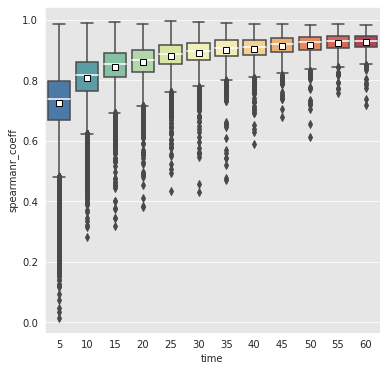

In [7]:
pairwise_spearmanr_coeffs_per_chunk_mat = (pd.concat(pairwise_spearmanr_list, axis=0,
                                                     keys=time_chunks_filtered).T).reset_index(level=0)
pairwise_spearmanr_coeffs_per_chunk_mat = pairwise_spearmanr_coeffs_per_chunk_mat.set_axis(['time', 'spearmanr_coeff'],
                                                                                           axis='columns')

fig = plt.figure(figsize=(6,6))
sns.boxplot(data=pairwise_spearmanr_coeffs_per_chunk_mat, x='time', y='spearmanr_coeff', palette='Spectral_r',
                medianprops={'color':'white'}, showmeans=True,
                meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"});

## Data analysis

#### Inputs

In [6]:
# regressors
dummies_variables_names = ['dataset']
participants_info_encoded = clustering.encoded_dummies_variables(participants_info_merged, dummies_variables_names)
regressors = participants_info_encoded.drop(columns=['sex','age'])

# pre-clustering inputs
scaling_axis = 1
pca_var = 3
pca = PCA(pca_var)

# clustering inputs
nb_cluster_min = 2
nb_cluster_max = 6
opt_cluster_nbr = 3


#### Calculate principal components analysis for 5 hours

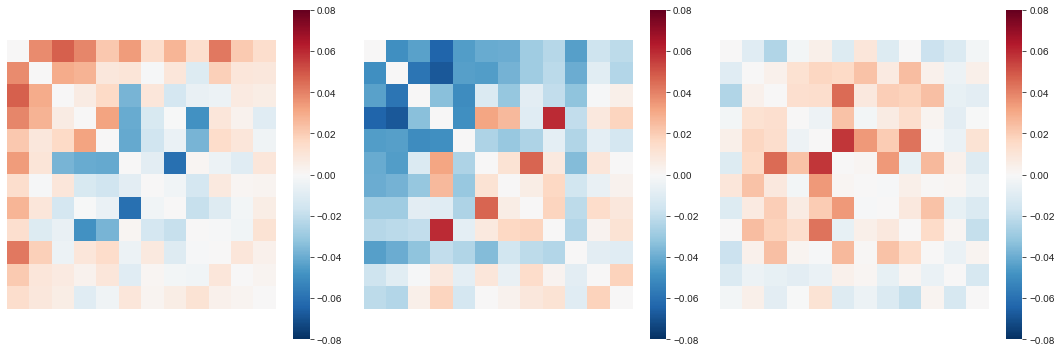

In [9]:
delta_t_5hours = '300'
matricesFiles_path = clustering.get_minMatrix(connectomes_matrices_extracted_dirpath, datasets_names_list,
                                              atlas_name, str(slidwin_initial), delta_t_5hours)
matrixFile_path = matricesFiles_path[0]
connectomes_matrices_5hours = clustering.create_connMatrix(connectomes_matrices_extracted_dirpath, datasets_names_list,
                                                           atlas_name, str(slidwin_initial), delta_t_5hours,
                                                           matrixFile_path)
connectomes_matrices_5hours_residual = clustering.calcul_residualMatrix(regressors,connectomes_matrices_5hours)
connectomes_matrices_5hours_residual_scaled = scale(X=connectomes_matrices_5hours_residual, axis=scaling_axis)
pca_global = pca.fit(X=connectomes_matrices_5hours_residual_scaled)
connectomes_matrices_5hours_residual_pca_global = pca_global.transform(X=connectomes_matrices_5hours_residual_scaled)
clustering_labels_results_5hoursignals = clustering.apply_clustering_methods(connectomes_matrices_5hours_residual_pca_global,
                                                                             nb_cluster_min, nb_cluster_max)
coocurence_matrix_5hoursignals = clustering.calculate_coocurence_matrix(clustering_labels_results_5hoursignals)
coocurence_matrix_5hoursignals_linked = linkage(coocurence_matrix_5hoursignals, method='ward')

clusters_5hoursignals = fcluster(coocurence_matrix_5hoursignals_linked, opt_cluster_nbr, criterion='maxclust')

connectomes_matrices_5hours_grouped = connectomes_matrices_5hours_residual.groupby(clusters_5hoursignals).mean()
connectomes_means_5hours = connectomes_matrices_5hours_grouped - connectomes_matrices_5hours_residual.mean()
clusters_names = {1:'1_5hours', 2:'2_5hours', 3:'3_5hours'}
connectomes_means_5hours = connectomes_means_5hours.rename(index=clusters_names)

n_cols = opt_cluster_nbr
n_rows = 1
fig, axs = plt.subplots(ncols = n_cols, nrows = n_rows, figsize=(15,5))

for i in range(n_cols):
    sns.heatmap(clustering.vec_to_sym(connectomes_means_5hours.iloc[i,:]), vmin=-0.08, vmax=0.08, cmap='RdBu_r',
                square=True, cbar=True, ax=axs[i], yticklabels = False, xticklabels = False);
fig.tight_layout();


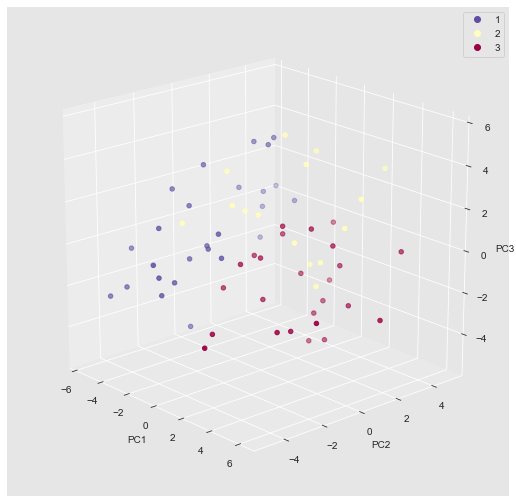

In [12]:
clusters_5hoursignals_df = pd.DataFrame(data = clusters_5hoursignals, columns=['clusters'])
connectomes_matrices_5hours_residual_pca_global_df = pd.DataFrame(data = connectomes_matrices_5hours_residual_pca_global,
                                                                  columns=['PC1','PC2','PC3'])

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
x = connectomes_matrices_5hours_residual_pca_global_df['PC1']
y = connectomes_matrices_5hours_residual_pca_global_df['PC2']
z = connectomes_matrices_5hours_residual_pca_global_df['PC3']

scatter = ax.scatter(x,y,z, marker="o", c=clusters_5hoursignals_df, s=20, cmap="Spectral_r")
ax.set_xlabel('PC1');
ax.set_ylabel('PC2');
ax.set_zlabel('PC3');
ax.view_init(azim=-42, elev=20);
classes = ['1','2','3']
plt.legend(handles=scatter.legend_elements()[0], labels=classes);
plt.show();


In [32]:
participants_info_merged['clusters'] = clusters_5hoursignals
contingency_site = pd.crosstab(participants_info_merged['dataset'], participants_info_merged['clusters'])
contingency_sex = pd.crosstab(participants_info_merged['sex'], participants_info_merged['clusters'])

# Chi-square test of independence.
c_site, p_value_site, dof, expected = chi2_contingency(contingency_site)
c_sex, p_value_sex, dof, expected = chi2_contingency(contingency_sex)

#### Apply consensus clustering per time chunk

In [10]:
pairwise_substract_between_connectomes_means_per_chunk_list = []
pairwise_spearmanr_between_connectomes_means_per_chunk_list = []
metrics_per_chunk_list = []
connectomes_means_toplot_list = []

for delta_t in time_chunks_filtered:
    #delta_t = time_chunks_filtered[-1]
    connectomes_means_list = []
    connectomes_means_keys_multiindex = []
    metrics_list = []
    pairwise_substract_between_connectomes_means_list = []
    pairwise_spearmanr_between_connectomes_means_list = []

    for slidwin in range(sliding_windows_number):
        clusters_delta_t = []
        connectomes_means_list_per_slidwin = []
        connectomes_means_keys_multiindex_per_slidwin = []
        matricesFiles_path = clustering.get_minMatrix(connectomes_matrices_extracted_dirpath, datasets_names_list,
                                                      atlas_name, str(slidwin), str(delta_t))

        for matrixFile_path in matricesFiles_path:
            connectomes_matrices = clustering.create_connMatrix(connectomes_matrices_extracted_dirpath, datasets_names_list,
                                                                atlas_name, str(slidwin), str(delta_t), matrixFile_path)
            connectomes_matrices_residual = clustering.calcul_residualMatrix(regressors,connectomes_matrices)
            connectomes_matrices_residual_scaled = scale(X=connectomes_matrices_residual, axis=scaling_axis)
            connectomes_matrices_residual_pca = pca_global.transform(X=connectomes_matrices_residual_scaled)
            clustering_labels_results = clustering.apply_clustering_methods(connectomes_matrices_residual_pca, nb_cluster_min,
                                                                    nb_cluster_max)
            coocurence_matrix = clustering.calculate_coocurence_matrix(clustering_labels_results)
            coocurence_matrix_linked = linkage(coocurence_matrix, method='ward')
            clusters = fcluster(coocurence_matrix_linked, opt_cluster_nbr, criterion='maxclust')
            clusters_delta_t.append(clusters)
            connectomes_means = connectomes_matrices_residual.groupby(clusters).mean() - connectomes_matrices_residual.mean()
            matching_biotypes_dict = clustering.match_biotypes(connectomes_means, connectomes_means_5hours)
            connectomes_means_renamed = connectomes_means.rename(index = matching_biotypes_dict).sort_index()
            connectomes_means_list_per_slidwin.append(connectomes_means_renamed)
            connectomes_means_keys_multiindex_per_slidwin.append(tuple([delta_t, matrixFile_path]))
            if delta_t == 60:
                connectomes_means_toplot_list.append(connectomes_means)
        connectomes_means_per_chunk = pd.concat(connectomes_means_list_per_slidwin, axis=0,
                                                keys = connectomes_means_keys_multiindex_per_slidwin).swaplevel(i=1,j=2)
        pairwise_substract_between_connectomes_means = clustering.calculate_pairwise_connectomes_substracts_per_chunk(connectomes_means_per_chunk)
        pairwise_substract_between_connectomes_means_list.append(pairwise_substract_between_connectomes_means)

        pairwise_spearmanr_between_connectomes_means = clustering.calculate_pairwise_spearmanr_per_chunk(connectomes_means_per_chunk)
        pairwise_spearmanr_between_connectomes_means_list.append(pairwise_spearmanr_between_connectomes_means)

        metrics = clustering.calcul_metric(clusters_delta_t)
        metrics_list.append(metrics)

    pairwise_substract_between_connectomes_means_per_chunk = pd.concat(pairwise_substract_between_connectomes_means_list).reset_index(drop=True)
    pairwise_substract_between_connectomes_means_per_chunk_list.append(pairwise_substract_between_connectomes_means_per_chunk)

    pairwise_spearmanr_between_connectomes_means_per_chunk = pd.concat(pairwise_spearmanr_between_connectomes_means_list).reset_index(drop=True)
    pairwise_spearmanr_between_connectomes_means_per_chunk_list.append(pairwise_spearmanr_between_connectomes_means_per_chunk)

    metrics_per_chunk = pd.concat(metrics_list).reset_index(drop=True)
    metrics_per_chunk_list.append(metrics_per_chunk)

In [43]:
# save variables 
# pickle.dump(metrics_per_chunk_list,open('metrics_per_chunk_list.dat','wb'))
# pickle.dump(connectomes_means_toplot_list,open('connectomes_means_toplot_list.dat','wb'))
# pickle.dump(pairwise_substract_between_connectomes_means_per_chunk_list,open('pairwise_substract_between_connectomes_means_per_chunk_list.dat','wb'))
# pickle.dump(pairwise_spearmanr_between_connectomes_means_per_chunk_list,open('pairwise_spearmanr_between_connectomes_means_per_chunk_list.dat','wb'))

In [ ]:
# load variable 
# metrics_per_chunk_list = pickle.load(open('metrics_per_chunk_list.dat','rb'))
# connectomes_means_toplot_list = pickle.load(open('connectomes_means_toplot_list.dat','rb'))
# pairwise_substract_between_connectomes_means_per_chunk_list = pickle.load(open('pairwise_substract_between_connectomes_means_per_chunk_list.dat','rb'))
# pairwise_spearmanr_between_connectomes_means_per_chunk_list = pickle.load(open('pairwise_spearmanr_between_connectomes_means_per_chunk_list.dat','rb'))


<AxesSubplot:xlabel='time', ylabel='metrics'>

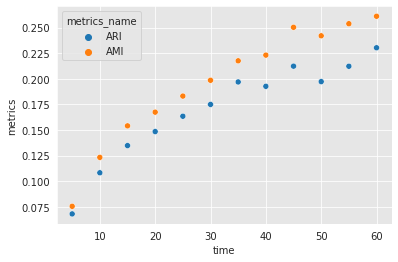

In [14]:
metrics_byTime_globalpca = pd.concat(metrics_per_chunk_list, keys=time_chunks_filtered, axis=1)

metrics_byTime_mean_globalpca = metrics_byTime_globalpca.mean(axis=0).reset_index()
metrics_byTime_mean_globalpca.columns = ['time','metrics_name', 'metrics']
sns.scatterplot(data = metrics_byTime_mean_globalpca, x = 'time', y = 'metrics', hue= 'metrics_name')


#### Results analysis

 Clustering results evaluation: ARI and AMI

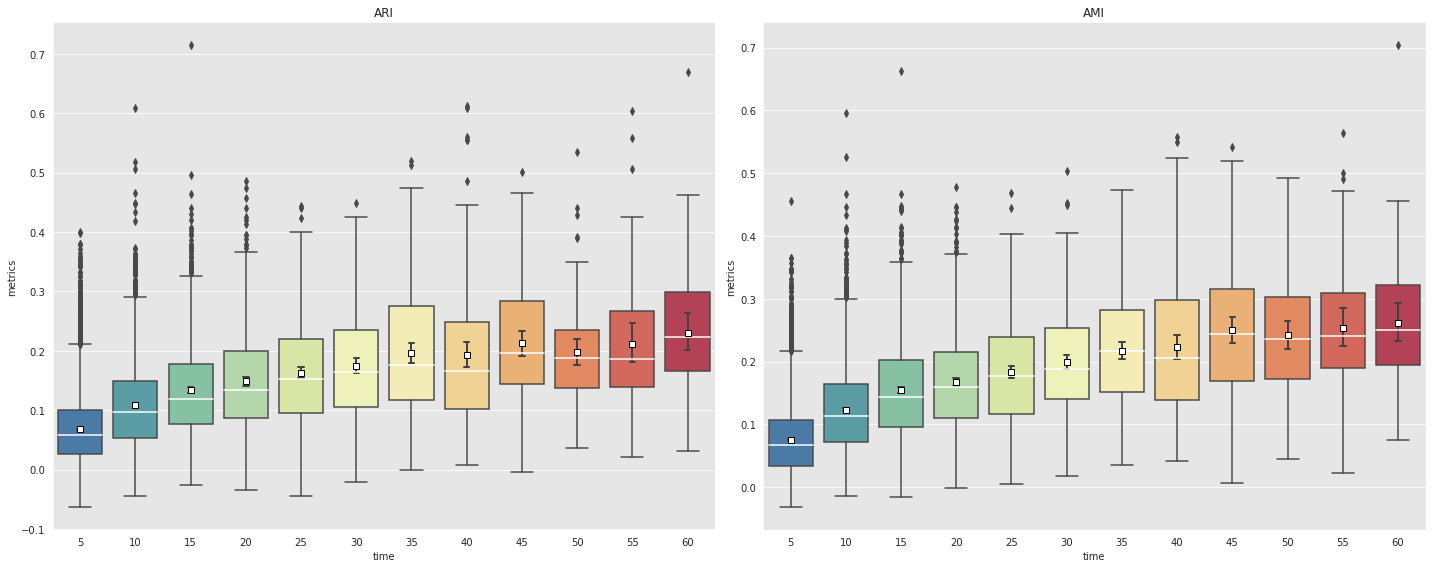

In [15]:
metrics_byTime_melt_globalpca = pd.melt(metrics_byTime_globalpca, var_name = ['time','metrics_name'], value_name='metrics')
metrics_names_list = metrics_byTime_melt_globalpca['metrics_name'].unique()
n_rows = 1
n_cols = len(metrics_names_list)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20,8))

for i, metric_name in enumerate(metrics_names_list):
    metric_per_timechunks = metrics_byTime_melt_globalpca[metrics_byTime_melt_globalpca['metrics_name']==metric_name]
    sns.boxplot(ax=axs[i], x='time', y='metrics', data=metric_per_timechunks, palette='Spectral_r',
                medianprops={'color':'white'}, showmeans=True,
                meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"});
    kwargs = {'alpha':0};
    sns.barplot(ax=axs[i], x='time', y='metrics', data=metric_per_timechunks, palette='Spectral_r', capsize=.1,
                n_boot=1000, ci=95, errwidth=2, **kwargs);
    axs[i].set_title(metric_name);
fig.tight_layout();
plt.show();

In [16]:
pd.set_option('display.max_columns', 1000)

metric_name = 'AMI'
ami_per_chunks = metrics_byTime_globalpca.xs(metric_name, axis=1, level=1)
kruskal_test_results = clustering.apply_kruskal_test(ami_per_chunks)
pairwise_mannwhitneyu_pvalues = clustering.apply_mannwhitneyu(ami_per_chunks)

print('Kruskal-Wallis H-test')
kruskal_test_results
pairwise_mannwhitneyu_pvalues.T.style.set_table_attributes("style='display:inline'").set_caption('Mann-Whitney U rank test')

Kruskal-Wallis H-test


KruskalResult(statistic=3740.785131466741, pvalue=0.0)

,"(5, 10)","(10, 15)","(15, 20)","(20, 25)","(25, 30)","(30, 35)","(35, 40)","(40, 45)","(45, 50)","(50, 55)","(55, 60)"
p_values,0.000000,0.000000,0.000517,0.003294,0.034448,0.043478,0.938352,0.021150,0.638322,0.655599,0.727737


Biotypes means comparison: Spearman/Pearson coefficients and errors

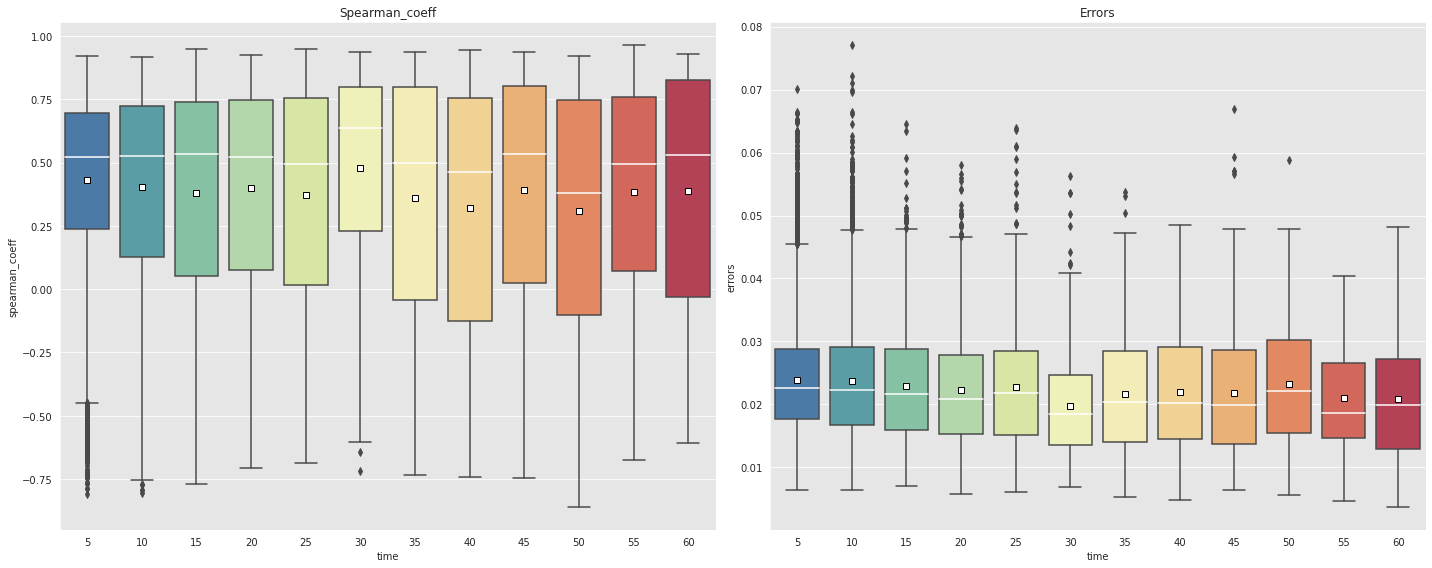

In [17]:
pairwise_substract_between_connectomes_means_per_times = (pd.concat(pairwise_substract_between_connectomes_means_per_chunk_list,
                                                                    axis=0,
                                                                    keys=time_chunks_filtered).T).reset_index(level=0)
pairwise_substract_between_connectomes_means_per_times = pairwise_substract_between_connectomes_means_per_times.set_axis(['time', 'errors'],
                                                                                           axis='columns')

pairwise_spearman_between_connectomes_means_per_times = (pd.concat(pairwise_spearmanr_between_connectomes_means_per_chunk_list,
                                                                    axis=0,
                                                                    keys=time_chunks_filtered).T).reset_index(level=0)
pairwise_spearman_between_connectomes_means_per_times = pairwise_spearman_between_connectomes_means_per_times.set_axis(['time', 'spearman_coeff'],
                                                                                           axis='columns')


n_rows = 1
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20,8))

sns.boxplot(data=pairwise_spearman_between_connectomes_means_per_times, x='time', y='spearman_coeff', palette='Spectral_r',
            ax=axs[0], medianprops={'color':'white'}, showmeans=True,
            meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"});
axs[0].set_title('Spearman_coeff');


sns.boxplot(data=pairwise_substract_between_connectomes_means_per_times, x='time', y='errors', palette='Spectral_r',
            ax=axs[1], medianprops={'color':'white'}, showmeans=True,
            meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"});
axs[1].set_title('Errors');
fig.tight_layout();
plt.show();

## Biotypes reproducibility vs individual connectomes reproducibility

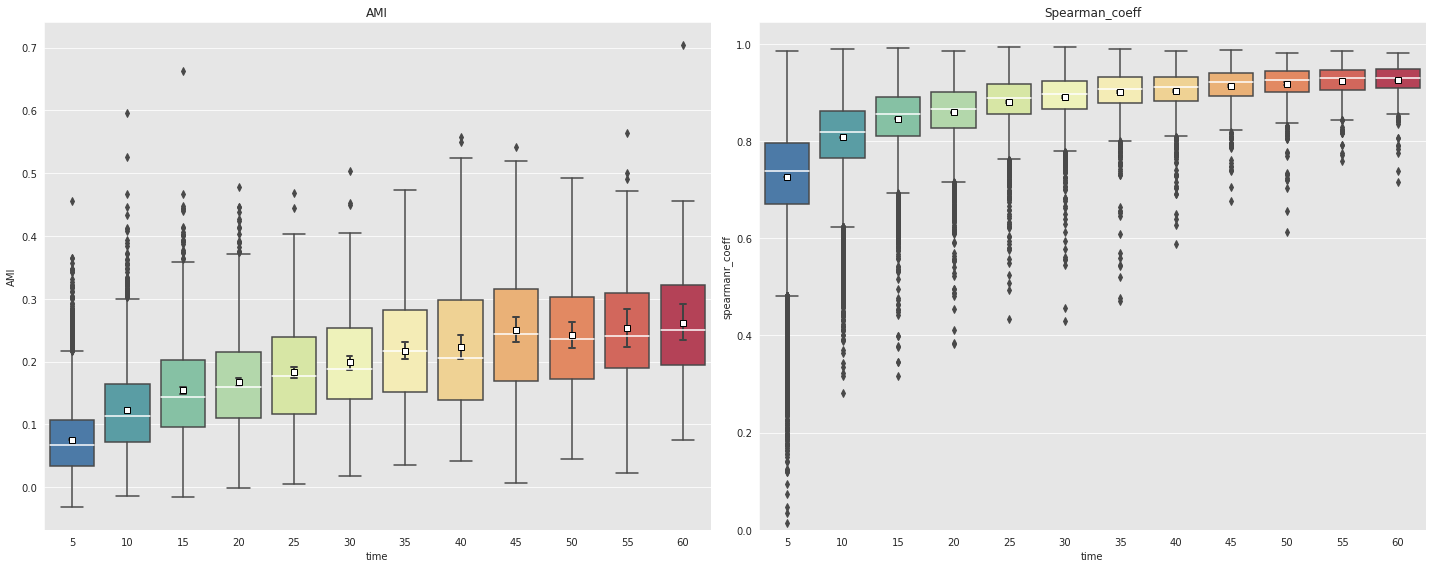

In [18]:
n_rows = 1
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20,8))
metric_name = 'AMI'
metric_per_timechunks = metrics_byTime_melt_globalpca[metrics_byTime_melt_globalpca['metrics_name']==metric_name]
metric_per_timechunks = metric_per_timechunks.rename(columns={'metrics':metric_name}).drop(columns=['metrics_name'])

sns.boxplot(ax=axs[0], x='time', y=metric_name, data=metric_per_timechunks, palette='Spectral_r',
            medianprops={'color':'white'}, showmeans=True,
            meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"});
kwargs = {'alpha':0};
sns.barplot(ax=axs[0], x='time', y=metric_name, data=metric_per_timechunks, palette='Spectral_r', capsize=.1,
            n_boot=1000, ci=95, errwidth=2, **kwargs);
axs[0].set_title(metric_name);

sns.boxplot(data=pairwise_spearmanr_coeffs_per_chunk_mat, x='time', y='spearmanr_coeff', palette='Spectral_r', ax=axs[1],
                medianprops={'color':'white'}, showmeans=True,
                meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"});
kwargs = {'alpha':0};
sns.barplot(ax=axs[1], x='time', y='spearmanr_coeff', data=pairwise_spearmanr_coeffs_per_chunk_mat, palette='Spectral_r',
            capsize=.1, n_boot=1000, ci=95, errwidth=2, **kwargs);
axs[1].set_title('Spearman_coeff');
fig.tight_layout();
plt.show();


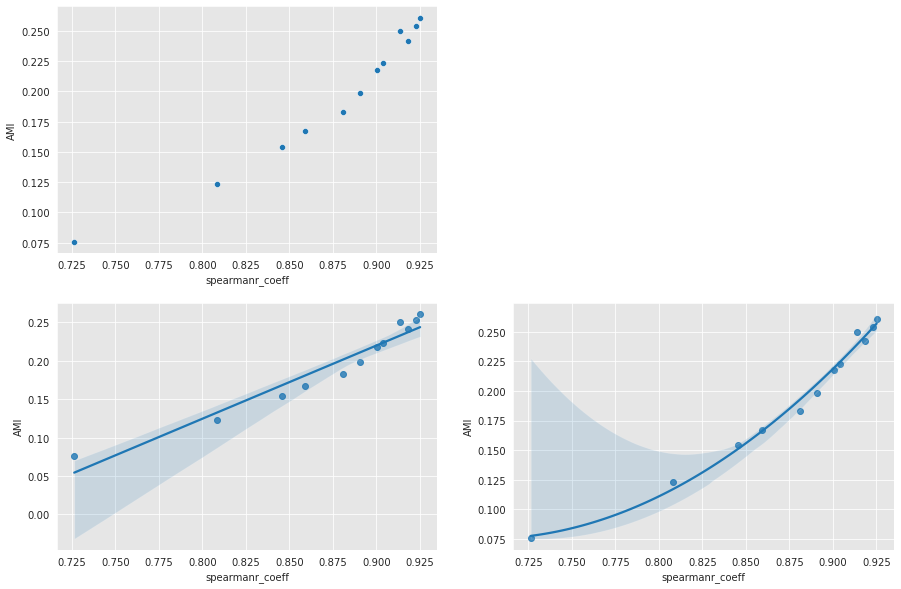

In [19]:
pairwise_spearmanr_coeffs_means_per_timechunk = pairwise_spearmanr_coeffs_per_chunk_mat.groupby('time').mean()
ami_means_per_timechunk = metric_per_timechunks.groupby('time').mean()
reproducibility_metrics_means = pd.concat([pairwise_spearmanr_coeffs_means_per_timechunk, ami_means_per_timechunk], axis=1)

fig, axs = plt.subplots(2,2, figsize= (15,10))
sns.scatterplot(data= reproducibility_metrics_means, x='spearmanr_coeff', y='AMI', ax=axs[0,0])
axs[0,1].axis('off')
sns.regplot(data= reproducibility_metrics_means, x='spearmanr_coeff', y='AMI', order=1, ax=axs[1,0])
sns.regplot(data= reproducibility_metrics_means, x='spearmanr_coeff', y='AMI', order=2, ax=axs[1,1])
plt.show();